In [1]:
import torch
import pytorch_lightning as pl
from src.temporal_model import TemporalModel 
from torchmetrics import Accuracy, Precision, Recall
import torch
from PIL import Image
import glob
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt


In [3]:

# Helper function to convert bounding box format
def xywh2xyxy(x: np.array):
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

# Define the image transformations (must match the ones used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Define a function to load and preprocess the images from a folder
def load_image_sequence(img_folder, get_tensor=True):
    img_list = glob.glob(f"{img_folder}/*.jpg")
    img_list.sort()

    images = [Image.open(file) for file in img_list]
    w, h = images[0].size

    # Collect labels for bounding boxes (assuming one label per image)
    labels = []
    for file in img_list:
        label_file = file.replace("images", "labels").replace(".jpg", ".txt")
        with open(label_file, "r") as f:
            lines = f.readlines()
        # Assuming the first line in each label file contains the necessary bounding box info
        labels.append(np.array(lines[0].split(" ")[1:5]).astype("float"))

    labels = np.array(labels)
    labels = xywh2xyxy(labels)

    x0, y0 = np.min(labels[:, :2], 0)
    x1, y1 = np.max(labels[:, 2:], 0)

    x0, y0, x1, y1 = int(x0 * w), int(y0 * h), int(x1 * w), int(y1 * h)
    xc = x0 + (x1 - x0) / 2
    yc = y0 + (y1 - y0) / 2
    crop_size = max(x1 - x0, y1 - y0) * 1.2

    if crop_size < 224:
        crop_x0 = max(int(xc - 224 / 2), 0)
        crop_x1 = min(int(xc + 224 / 2), w)
        crop_y0 = max(int(yc - 224 / 2), 0)
        crop_y1 = min(int(yc + 224 / 2), h)
    else:
        crop_x0 = max(int(xc - crop_size / 2), 0)
        crop_x1 = min(int(xc + crop_size / 2), w)
        crop_y0 = max(int(yc - crop_size / 2), 0)
        crop_y1 = max(int(yc + crop_size / 2), h)

    img_sequence = []

    # Crop, resize, and transform each image in the sequence
    for im in images:
        cropped_image = im.crop((crop_x0, crop_y0, crop_x1, crop_y1))
        if crop_size > 224:
            cropped_image = cropped_image.resize((224, 224))

        if transform and get_tensor:
            cropped_image = transform(cropped_image)

        img_sequence.append(cropped_image)

    # Stack the images into a tensor with shape (sequence_length, C, H, W)
    if get_tensor:
        img_sequence = torch.stack(img_sequence, dim=0)

    return img_sequence

# Define the inference function
def inference(img_folder, model, device='cpu'):
    # Load and preprocess the image sequence
    img_sequence = load_image_sequence(img_folder).unsqueeze(0)  # Add batch dimension

    # Move the images to the appropriate device (GPU or CPU)
    img_sequence = img_sequence.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Pass the image sequence through the model
        predictions = model(img_sequence)

    predicted_class = predictions.item()

    # Since this is a binary classification, threshold at 0.5 to determine class
    predicted_label = 1 if predicted_class >= 0.5 else 0

    return predicted_label, predicted_class



In [4]:
from collections import OrderedDict
# Load the checkpoint
model_path = "model_checkpoints/fire_model-epoch=13-val_recall=0.9119.ckpt"
checkpoint = torch.load(model_path)

# Modify the state dict to remove 'model.' prefix
state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    name = k.replace("model.", "")  # Remove 'model.' prefix
    new_state_dict[name] = v

# Load the modified state dict into the TemporalModel
model = TemporalModel().cuda()
model.load_state_dict(new_state_dict)

# Define the folder containing the images for inference
img_folder = "temporal_ds/images/val/1/1651"

# Perform inference on CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predicted_label, predicted_prob = inference(img_folder, model, device=device)

# Print the result
print(f"Predicted Label: {predicted_label}, Predicted Probability: {predicted_prob}")

/tmp/ipykernel_341422/1090918939.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Predicted Label: 1, Predicted Probability: 0.9998421669006348


In [5]:
folders = glob.glob("temporal_ds/images/val/**/*")

In [6]:
for folder in folders:
    predicted_label, predicted_prob = inference(folder, model, device=device)
    label = int(folder.split("/")[-2])
    if predicted_label != label:
        print(folder, label, predicted_label, predicted_prob)
        


temporal_ds/images/val/0/148 0 1 0.9957205653190613
temporal_ds/images/val/0/1713 0 1 0.9944097399711609
temporal_ds/images/val/0/1892 0 1 0.9997692704200745
temporal_ds/images/val/0/1147 0 1 0.9957104921340942
temporal_ds/images/val/0/511 0 1 0.9506229758262634
temporal_ds/images/val/0/1984 0 1 0.8463613390922546
temporal_ds/images/val/0/4246 0 1 0.9988067150115967
temporal_ds/images/val/0/415 0 1 0.999237060546875
temporal_ds/images/val/0/275 0 1 0.9997370839118958
temporal_ds/images/val/0/506 0 1 0.9240883588790894
temporal_ds/images/val/0/1605 0 1 0.9645008444786072
temporal_ds/images/val/0/1994 0 1 0.9253361225128174
temporal_ds/images/val/0/1092 0 1 0.6590588688850403
temporal_ds/images/val/0/466 0 1 0.99886155128479
temporal_ds/images/val/0/446 0 1 0.7364112734794617
temporal_ds/images/val/0/647 0 1 0.9455118775367737
temporal_ds/images/val/0/671 0 1 0.9947381615638733
temporal_ds/images/val/1/1760 1 0 0.0022345506586134434
temporal_ds/images/val/1/1759 1 0 0.0022345506586134434

In [7]:
folder = "temporal_ds/images/val/1/1755"
images = load_image_sequence(folder, get_tensor=False)

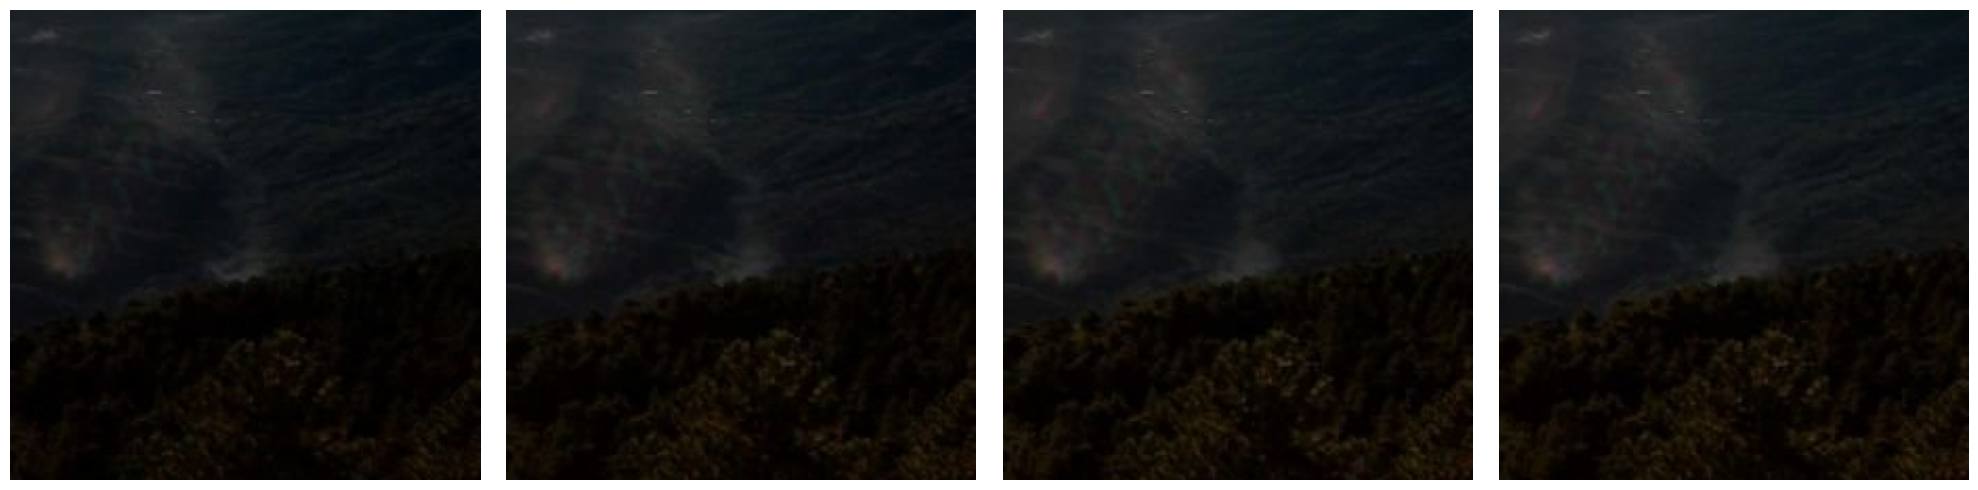

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

for i, im in enumerate(images): 

    # Display each image in the subplot
    axes[i].imshow(im)
    axes[i].axis('off')  # Turn off the axis for a cleaner look

# Display all images
plt.tight_layout()
plt.show()  